# RQ1: Does SATD in code comments correlate with high code complexity?

This Notebook contains the analysis for RQ1. The goal of this research question is to determine whether self-admitted technical debt (SATD) in code comments correlates with high code complexity. We will analyze the data to determine if methods with increased SATD comments have higher complexity changes compared to methods where SATD comments did not increase. We will also look at the relationship between SATD count and cyclomatic complexity.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu, shapiro, ttest_ind

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_context("notebook", font_scale=1.2)
colors = ["#4878D0", "#6ACC65"]
sns.set_palette(colors)

print("# RQ1: Does SATD in code comments correlate with high code complexity?")
print("## Specifically: How does complexity change when SATD increases vs. when it doesn't?\n")


# RQ1: Does SATD in code comments correlate with high code complexity?
## Specifically: How does complexity change when SATD increases vs. when it doesn't?



In [30]:
# Load the data
print("Loading data...")
df = pd.read_csv('combined_method_analysis (1).csv')


Loading data...


In [31]:
# Ensure necessary columns exist
assert 'satd_change' in df.columns and 'complexity_change' in df.columns, "Required columns missing!"

# Create binary flag for SATD increase
df['satd_increased'] = df['satd_change'] > 0

# Extract complexity changes for both groups
satd_increased = df[df['satd_increased']]['complexity_change']
satd_not_increased = df[~df['satd_increased']]['complexity_change']

# Print descriptive statistics
print("\n## Complexity Change Statistics:")
print(f"SATD Increased - Mean: {satd_increased.mean():.2f}, Median: {satd_increased.median():.2f}")
print(f"SATD Not Increased - Mean: {satd_not_increased.mean():.2f}, Median: {satd_not_increased.median():.2f}")



## Complexity Change Statistics:
SATD Increased - Mean: 3.13, Median: 1.00
SATD Not Increased - Mean: 0.35, Median: 1.00


In [32]:
# Shapiro-Wilk test for normality (subsampling if dataset is large)
max_sample = 5000
satd_inc_sample = satd_increased.sample(min(max_sample, len(satd_increased))) if len(satd_increased) > max_sample else satd_increased
satd_not_inc_sample = satd_not_increased.sample(min(max_sample, len(satd_not_increased))) if len(satd_not_increased) > max_sample else satd_not_increased

_, p_satd_inc = shapiro(satd_inc_sample)
_, p_satd_not_inc = shapiro(satd_not_inc_sample)

print("\n## Testing for Normality:")
print(f"Shapiro-Wilk p-value for SATD Increased: {p_satd_inc:.10e}")
print(f"Shapiro-Wilk p-value for SATD Not Increased: {p_satd_not_inc:.10e}")



## Testing for Normality:
Shapiro-Wilk p-value for SATD Increased: 1.1674217506e-41
Shapiro-Wilk p-value for SATD Not Increased: 0.0000000000e+00


In [33]:
# Choose appropriate test
alpha = 0.05
if p_satd_inc > alpha and p_satd_not_inc > alpha:
    # Normal distribution -> Use t-test
    test_name = "Independent samples t-test"
    t_stat, p_value = ttest_ind(satd_increased, satd_not_increased, equal_var=False)
    test_stat = f"t={t_stat:.4f}"
else:
    # Non-normal distribution -> Use Mann-Whitney U test
    test_name = "Mann-Whitney U test"
    u_stat, p_value = mannwhitneyu(satd_increased, satd_not_increased)
    test_stat = f"U={u_stat}"

print(f"\n## Statistical Test Results:")
print(f"{test_name}: {test_stat}, p={p_value:.10e}")



## Statistical Test Results:
Mann-Whitney U test: U=3857429.5, p=1.2804155915e-40


In [34]:
if p_value < alpha:
    print("Statistically significant difference found!")

    # Effect size calculation
    if test_name == "Mann-Whitney U test":
        n1, n2 = len(satd_increased), len(satd_not_increased)
        z_score = (u_stat - (n1 * n2 / 2)) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
        effect_size = abs(z_score) / np.sqrt(n1 + n2)
        effect_size_interp = "negligible" if effect_size < 0.1 else "small" if effect_size < 0.3 else "medium" if effect_size < 0.5 else "large"
        print(f"Effect size: r = {effect_size:.4f} ({effect_size_interp})")
    else:
        mean1, mean2 = satd_increased.mean(), satd_not_increased.mean()
        sd1, sd2 = satd_increased.std(), satd_not_increased.std()
        n1, n2 = len(satd_increased), len(satd_not_increased)
        pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
        cohen_d = abs(mean1 - mean2) / pooled_sd
        effect_size_interp = "negligible" if cohen_d < 0.2 else "small" if cohen_d < 0.5 else "medium" if cohen_d < 0.8 else "large"
        print(f"Effect size: Cohen's d = {cohen_d:.4f} ({effect_size_interp})")
else:
    print("No statistically significant difference found.")


Statistically significant difference found!
Effect size: r = 0.1124 (small)


/Users/mahshid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mahshid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


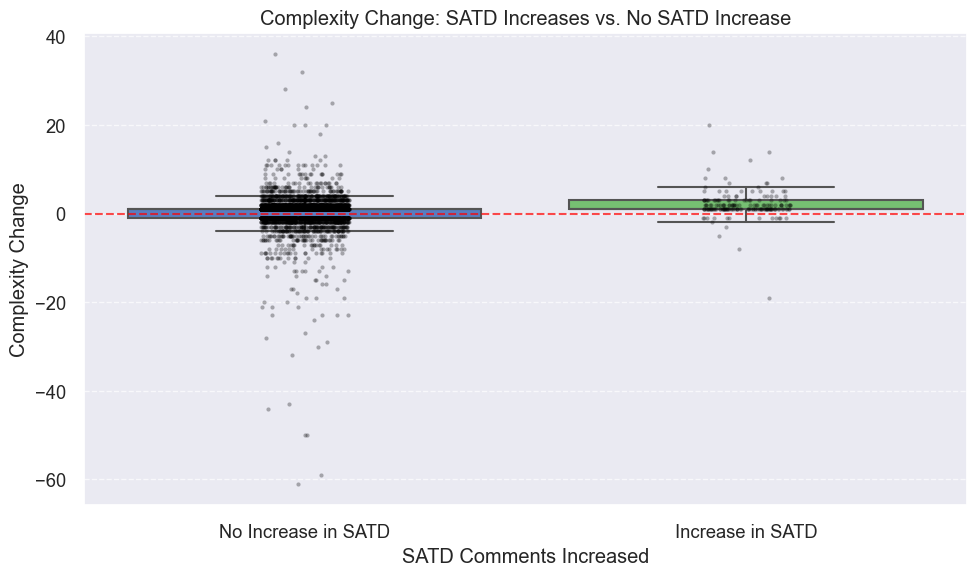

In [36]:
# Boxplot visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='satd_increased', y='complexity_change', data=df, showfliers=False)
sns.stripplot(x='satd_increased', y='complexity_change', data=df.sample(min(5000, len(df))), size=3, color='black', alpha=0.3, jitter=True)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Complexity Change: SATD Increases vs. No SATD Increase')
plt.xlabel('SATD Comments Increased')
plt.ylabel('Complexity Change')
plt.xticks([0, 1], ['No Increase in SATD', 'Increase in SATD'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.annotate(f"", xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='top', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))
plt.tight_layout()
plt.savefig('rq1_complexity_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

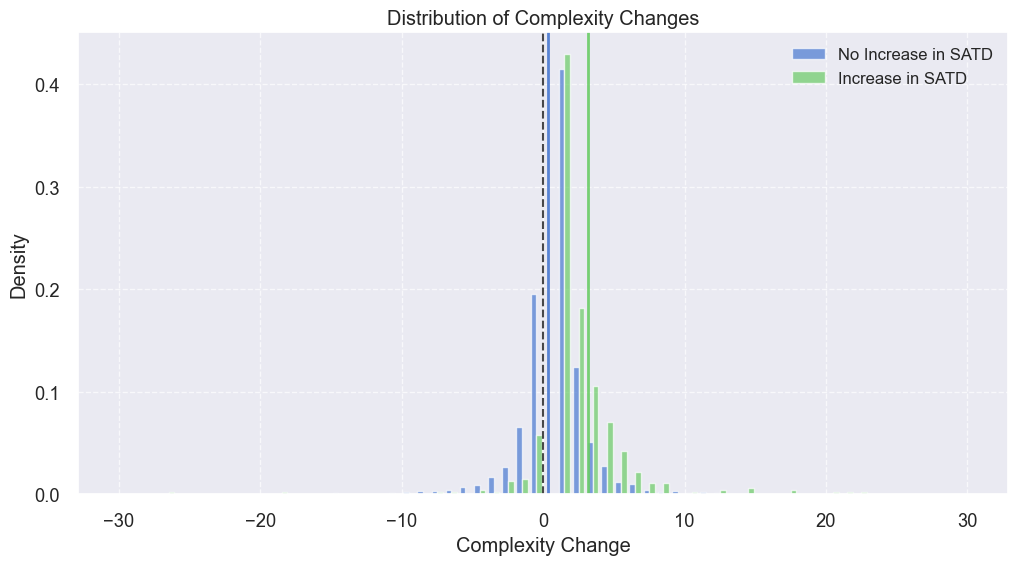

In [37]:
# Histogram of complexity changes
plt.figure(figsize=(12, 6))
bins = np.arange(-30, 31, 1)
plt.hist([satd_not_increased, satd_increased], bins=bins, label=['No Increase in SATD', 'Increase in SATD'], alpha=0.7, density=True)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.axvline(x=satd_not_increased.mean(), color=colors[0], linestyle='-', alpha=0.9, linewidth=2)
plt.axvline(x=satd_increased.mean(), color=colors[1], linestyle='-', alpha=0.9, linewidth=2)
plt.title('Distribution of Complexity Changes')
plt.xlabel('Complexity Change')
plt.ylabel('Density')
plt.legend(fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.savefig('rq1_complexity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()